# Segmenting and clustering Neighbourhoods of Toronto:

## importing necessary libraries

In [56]:
import pandas as pd
import numpy as np
import folium
from bs4 import BeautifulSoup  # for web-scraping
import requests
import matplotlib.pyplot as plt
%matplotlib inline

## accessing html content and reading the text data

In [57]:
data= requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
data= data.content

soup= BeautifulSoup(data)
table= soup.find('table')
tr= table.find_all('tr')

row= []
for tr in tr:
    td= tr.find_all('td')
    row.append([i.text for i in td])

## converting the data into the required dataframe and cleaning the data as required

In [58]:
row[0]= ['Postal Code','Borough', "Neighbourhood"]

df= pd.DataFrame(row)     # converting data to dataframe
df.columns= df.loc[0].tolist()
df= df.iloc[1:,:]

df['Postal Code']= [i[:-1] for i in df['Postal Code']]
df['Borough']= [i[:-1] for i in df['Borough']]
df['Neighbourhood']= [i[:-1] for i in df['Neighbourhood']]

df= df[df['Borough']!= 'Not assigned']  # removing any data entry that has a 'not assigned' borough

df.reset_index(inplace= True,drop= True)

for i in df.index:  
    if df.iloc[i,2]== "Not assigned":     # replacing 'not assigned' neighbourhood values with that of the borough
        df.iloc[i,2]= df.iloc[i,1]        

In [59]:
print('there are {} no. of rows in the dataframe'.format(df.shape[0]))

there are 103 no. of rows in the dataframe


### importing the geocoder library to calculate the latitude and longitude values of different neighbourhoods and adding it to the dataframe

In [31]:
#importing geocoder library
import geocoder

In [38]:
lat,lng= [],[]  #empty list for future append

for code,bor,nei in zip(df['Postal Code'],df['Borough'],df['Neighbourhood']):
    
    try:
        ll= geocoder.arcgis('{},{},{},Toronto'.format(code,nei,bor)).latlng
    except:
        ll= None
        
    lat.append(ll[0])  #appending the latitude and longitude values 
    lng.append(ll[1])
    
df['Latitude']= lat  #adding the data to the dataframe
df['Longitude']= lng 

In [3]:
#df= pd.read_csv('toronto').drop('Unnamed: 0',1)

In [4]:
df1= df[['Toronto' in bor for bor in df.Borough]]#.reset_index(inplace= True,drop= True)
df1.reset_index(inplace=True,drop= True)

In [30]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as col

In [73]:
latlng= geocoder.arcgis('Toronto').latlng

tor= folium.Map(latlng,zoom_start=12)

for nei,code,bor,lat,lng in zip(df1['Neighbourhood'],df1['Postal Code'],df1['Borough'],df1['Latitude'],df1['Longitude']):
    
    folium.CircleMarker(
            [lat,lng],
            color= 'red',
            radius=5,
            fill= True,
            fill_color= 'red',
            fill_opacity= 0.5,
            tooltip=bor,
            popup='[postal code]:  {} \n\n [neighbourhood]:  {}\n'.format(code,nei)
    ).add_to(tor)

tor    

In [6]:
df1.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.659208,-79.361443
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.660192,-79.390411
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.707744,-79.309408
3,M5C,Downtown Toronto,St. James Town,43.671100,-79.373590
4,M4E,East Toronto,The Beaches,43.674130,-79.296440


your credentials are __here__
<!--
CLIENT_ID = 'VOSZ5IO22Y2MTUL5V5F55VWJW1GQSBKXVC5OQDN2C0LR0PUF' # your Foursquare ID
CLIENT_SECRET = '2FB3FOFPLQQKRAVLZMGV5FPM2BIRVSO2GGZ3V2O5T4QNET3R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
-->

## Pulling request from foursquare API to get in formation of the nearby places:

In [46]:
data= []

for name,lat,lng in zip(df1.Neighbourhood,df1.Latitude,df1.Longitude):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
    
    res= requests.get(url).json()
    
    data.append([(name,lat,lng,i['venue']['name'],i['venue']['categories'][0]['name'],i['venue']['location']['lat'],i['venue']['location']['lng']) for i in res['response']['groups'][0]['items']])

In [81]:
df_fin= pd.DataFrame(data= [item for datas in data for item in datas],columns= ['Neighborhood','N_Latitude','N_Longitude','venue','venue_type', 'v_lat', 'v_lon' ])

In [95]:
df_fin

,Neighborhood,N_Latitude,N_Longitude,venue,venue_type,v_lat,v_lon
0,"Regent Park, Harbourfront",43.659208,-79.361443,Regent Park Aquatic Centre,Pool,43.660600,-79.361392
1,"Regent Park, Harbourfront",43.659208,-79.361443,Sumach Espresso,Coffee Shop,43.658135,-79.359515
2,"Regent Park, Harbourfront",43.659208,-79.361443,Daniels Spectrum,Performing Arts Venue,43.660137,-79.361808
3,"Regent Park, Harbourfront",43.659208,-79.361443,Paintbox Bistro,Restaurant,43.660050,-79.362855
4,"Regent Park, Harbourfront",43.659208,-79.361443,Sukhothai,Thai Restaurant,43.658444,-79.365681
...,...,...,...,...,...,...,...
1727,"Business reply mail Processing Centre, South C...",43.648690,-79.385440,Meli Baklava & Chocolate Bar,Chocolate Shop,43.650140,-79.390377
1728,"Business reply mail Processing Centre, South C...",43.648690,-79.385440,Ematei 絵馬亭,Japanese Restaurant,43.651156,-79.388990
1729,"Business reply mail Processing Centre, South C...",43.648690,-79.385440,Red Eye Espresso,Café,43.651150,-79.390146
1730,"Business reply mail Processing Centre, South C...",43.648690,-79.385440,Condom Shack,Hobby Shop,43.650542,-79.388138


In [137]:
one= pd.get_dummies(df_fin.venue_type) 
one['n_hood']= df_fin.Neighborhood
one= one[[one.columns[-1]]+list(one.columns[:-1])]  # dummyfied the venue categories

In [148]:
one_gr= one.groupby(['n_hood']).mean().reset_index()

In [62]:
df_sort= pd.DataFrame(columns= ['n_hood']+list(np.arange(1,11)))
df_sort['n_hood']= one_gr.n_hood

for ind in one_gr.index:
    df_sort.iloc[ind,1:]= one_gr.iloc[ind,1:].sort_values(ascending= False).index.values[:10]

#df_sort= pd.read_csv('final.csv')

In [63]:
df_sort # dataset containing the top 10 categories for each neighborhood

,Unnamed: 0,n_hood,1,2,3,4,5,6,7,8,9,10
0,0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel,Café,Beer Bar,Restaurant,Cheese Shop,Breakfast Spot,Bakery
1,1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Movie Theater,Burrito Place,Salon / Barbershop,Sandwich Place,Gym
2,2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Movie Theater,Burrito Place,Salon / Barbershop,Sandwich Place,Gym
3,3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Hotel,Restaurant,Italian Restaurant,Yoga Studio,Pizza Place,Beer Bar,Bar,Sandwich Place,Gym
4,4,Central Bay Street,Coffee Shop,Clothing Store,Hotel,Theater,Cosmetics Shop,Department Store,Diner,Plaza,Japanese Restaurant,Sandwich Place
5,5,Christie,Korean Restaurant,Café,Coffee Shop,Park,Sandwich Place,Grocery Store,Mexican Restaurant,Cocktail Bar,Karaoke Bar,Indian Restaurant
6,6,Church and Wellesley,Coffee Shop,Hotel,Gay Bar,Japanese Restaurant,Men's Store,Dance Studio,Sushi Restaurant,Café,Burger Joint,Restaurant
7,7,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant,American Restaurant,Japanese Restaurant,Gym,Seafood Restaurant,Tea Room
8,8,Davisville,Sandwich Place,Diner,Indian Restaurant,Café,Restaurant,Gas Station,Thai Restaurant,Italian Restaurant,Coffee Shop,Fast Food Restaurant
9,9,Davisville North,Sandwich Place,Diner,Indian Restaurant,Café,Restaurant,Gas Station,Thai Restaurant,Italian Restaurant,Coffee Shop,Fast Food Restaurant


In [66]:
one_gr # dataset containing the weights

,Unnamed: 0,n_hood,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,Berczy Park,0.000000,0.000000,0.000000,0.00000,0.015625,0.000000,0.000000,0.000,...,0.000000,0.00,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625
1,1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.020000,0.000000,0.00000,0.010000,0.000000,0.010000,0.020,...,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
2,2,"Business reply mail Processing Centre, South C...",0.000000,0.020000,0.000000,0.00000,0.010000,0.000000,0.010000,0.020,...,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
3,3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.00000,0.014085,0.000000,0.014085,0.000,...,0.000000,0.00,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028169
4,4,Central Bay Street,0.000000,0.000000,0.000000,0.00000,0.012821,0.012821,0.000000,0.000,...,0.000000,0.00,0.000000,0.012821,0.000000,0.012821,0.012821,0.000000,0.012821,0.000000
5,5,Christie,0.000000,0.017544,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000
6,6,Church and Wellesley,0.000000,0.012821,0.000000,0.00000,0.000000,0.000000,0.012821,0.000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,0.000000,0.012821
7,7,"Commerce Court, Victoria Hotel",0.000000,0.040000,0.000000,0.00000,0.010000,0.000000,0.000000,0.010,...,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000
8,8,Davisville,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,Davisville North,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## modeling and evaluation:

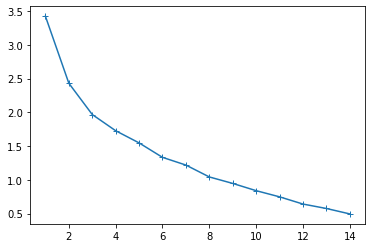

In [70]:
df_m= one_gr.drop(['n_hood','Unnamed: 0'],axis= 1)

from sklearn.cluster import KMeans

ine= []

for i in range(1,15):
    km= KMeans(n_clusters=i, init= 'k-means++', n_init= 12).fit(df_m)
    ine.append(km.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1,15),ine, '+-')
plt.show()

In [71]:
km= KMeans(n_clusters=3, init= 'k-means++', n_init= 12).fit(df_m) #choosing 3 clusters according to graph
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [39]:
clus= pd.DataFrame(columns= ['neighborhood']+[str(i+1) for i in range(10)])
clus['neighborhood']= one_gr['n_hood']

for i in range(len(clus)):
    clus.loc[i,1:]= df_m.loc[i,:].sort_values(ascending= False).index[:10]

In [41]:
clus['labels']= km.labels_

In [46]:
clus[clus['labels']==0]

,neighborhood,1,2,3,4,5,6,7,8,9,10,labels
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel,Café,Beer Bar,Restaurant,Cheese Shop,Breakfast Spot,Bakery,0
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Movie Theater,Burrito Place,Salon / Barbershop,Sandwich Place,Gym,0
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Movie Theater,Burrito Place,Salon / Barbershop,Sandwich Place,Gym,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Hotel,Restaurant,Italian Restaurant,Yoga Studio,Pizza Place,Beer Bar,Bar,Sandwich Place,Gym,0
4,Central Bay Street,Coffee Shop,Clothing Store,Hotel,Theater,Cosmetics Shop,Department Store,Diner,Plaza,Japanese Restaurant,Sandwich Place,0
5,Christie,Korean Restaurant,Café,Coffee Shop,Park,Sandwich Place,Grocery Store,Mexican Restaurant,Cocktail Bar,Karaoke Bar,Indian Restaurant,0
6,Church and Wellesley,Coffee Shop,Hotel,Gay Bar,Japanese Restaurant,Men's Store,Dance Studio,Sushi Restaurant,Café,Burger Joint,Restaurant,0
7,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant,American Restaurant,Japanese Restaurant,Gym,Seafood Restaurant,Tea Room,0
8,Davisville,Sandwich Place,Diner,Indian Restaurant,Café,Restaurant,Gas Station,Thai Restaurant,Italian Restaurant,Coffee Shop,Fast Food Restaurant,0
9,Davisville North,Sandwich Place,Diner,Indian Restaurant,Café,Restaurant,Gas Station,Thai Restaurant,Italian Restaurant,Coffee Shop,Fast Food Restaurant,0


In [72]:
clus[clus['labels']==1]

,neighborhood,1,2,3,4,5,6,7,8,9,10,labels
12,"Forest Hill North & West, Forest Hill Road Park",Gym / Fitness Center,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,1


In [73]:
clus[clus['labels']==2]

,neighborhood,1,2,3,4,5,6,7,8,9,10,labels
32,Studio District,Miscellaneous Shop,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,2


__from the above clusters we can infer__
* cluster 0 has restaurants and coffee shops as the nearest places (which is the majority)
* cluster 1 has fitness centre as the nearest
* cluster 2 has miscellaneous shop a sthe nearest.

In [74]:
#clus.to_csv('completed.csv')